To import all the standard libraries:


In [57]:
# Import pandas, numpy, and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# seaborn is a data visualization library built on matplotlib
import seaborn as sns


# Model preprocessing
from sklearn.preprocessing import StandardScaler

# Modeling
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Model metrics and analysis
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.anova import anova_lm

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator


In [58]:
# set the plotting style
sns.set_style("whitegrid")

To import our dataset:

In [59]:
#To load our cleaned dataset from GitHub:
education_df = pd.read_csv(
    'https://raw.githubusercontent.com/kembaoak/education/refs/heads/main/data/education_clean_version.csv'
)

To view the imported dataset:

In [60]:
education_df.head()

,id,school_type,school_level,charter,year,state,zip_code,percent_college,rate_unemployment,percent_married,median_income,average_act,percent_lunch,fte_teachers
0,1.000016e+11,Regular School,High,Yes,2016-2017,DE,19804,0.445283,0.117962,0.346495,42820.0,20.433455,0.066901,25.0
1,1.000080e+11,Regular School,High,No,2016-2017,DE,19709,0.662765,0.063984,0.767619,89320.0,19.498168,0.112412,87.0
2,1.000080e+11,Regular School,High,No,2016-2017,DE,19709,0.701864,0.056460,0.713090,84140.0,19.554335,0.096816,95.0
3,1.000170e+11,Regular School,High,No,2016-2017,DE,19958,0.692062,0.044739,0.641283,56500.0,17.737485,0.296960,98.0
4,1.000180e+11,Regular School,High,No,2016-2017,DE,19934,0.640060,0.077014,0.834402,54015.0,18.245421,0.262641,134.0


To understand  the relationship between our predictor variables and our target variables we can construct a correlation matrix. The correlation matrix 

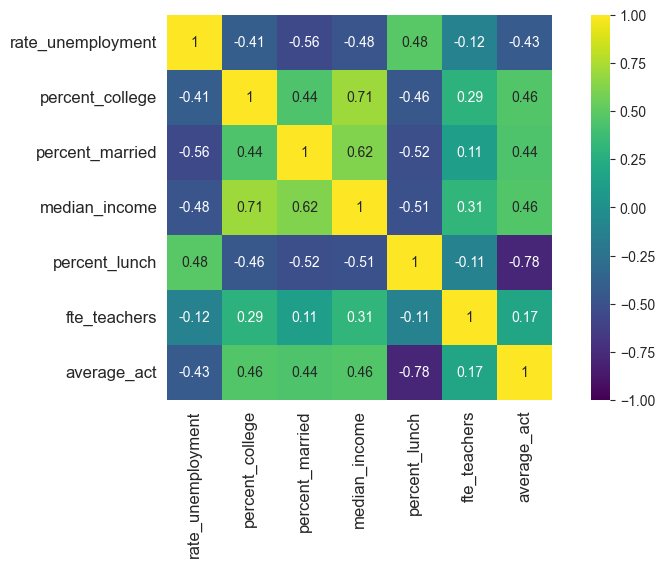

In [61]:
predictor_variables = ['rate_unemployment', 'percent_college', 'percent_married', 'median_income', 'percent_lunch', 'state', 'charter', 'fte_teachers']

numerical_predictors = education_df[predictor_variables].select_dtypes(include='number').columns.to_list()

corr_matrix = education_df[numerical_predictors + ["average_act"]].corr()

plt.figure(figsize=(10, 5))

sns.heatmap(
    corr_matrix, vmax=1, vmin=-1, square=True, annot=True, cmap="viridis"
)

plt.tick_params(labelsize=12)

plt.show()

The correlation matrix just show the relationships that exists between the average_act and the predictor variables.
We can see that percent_lunch has the r value that is closest to -1 or 1. This indicate that it is the strongest predictor of ACT performance.

To make a pairplot to explore relationships between data: 

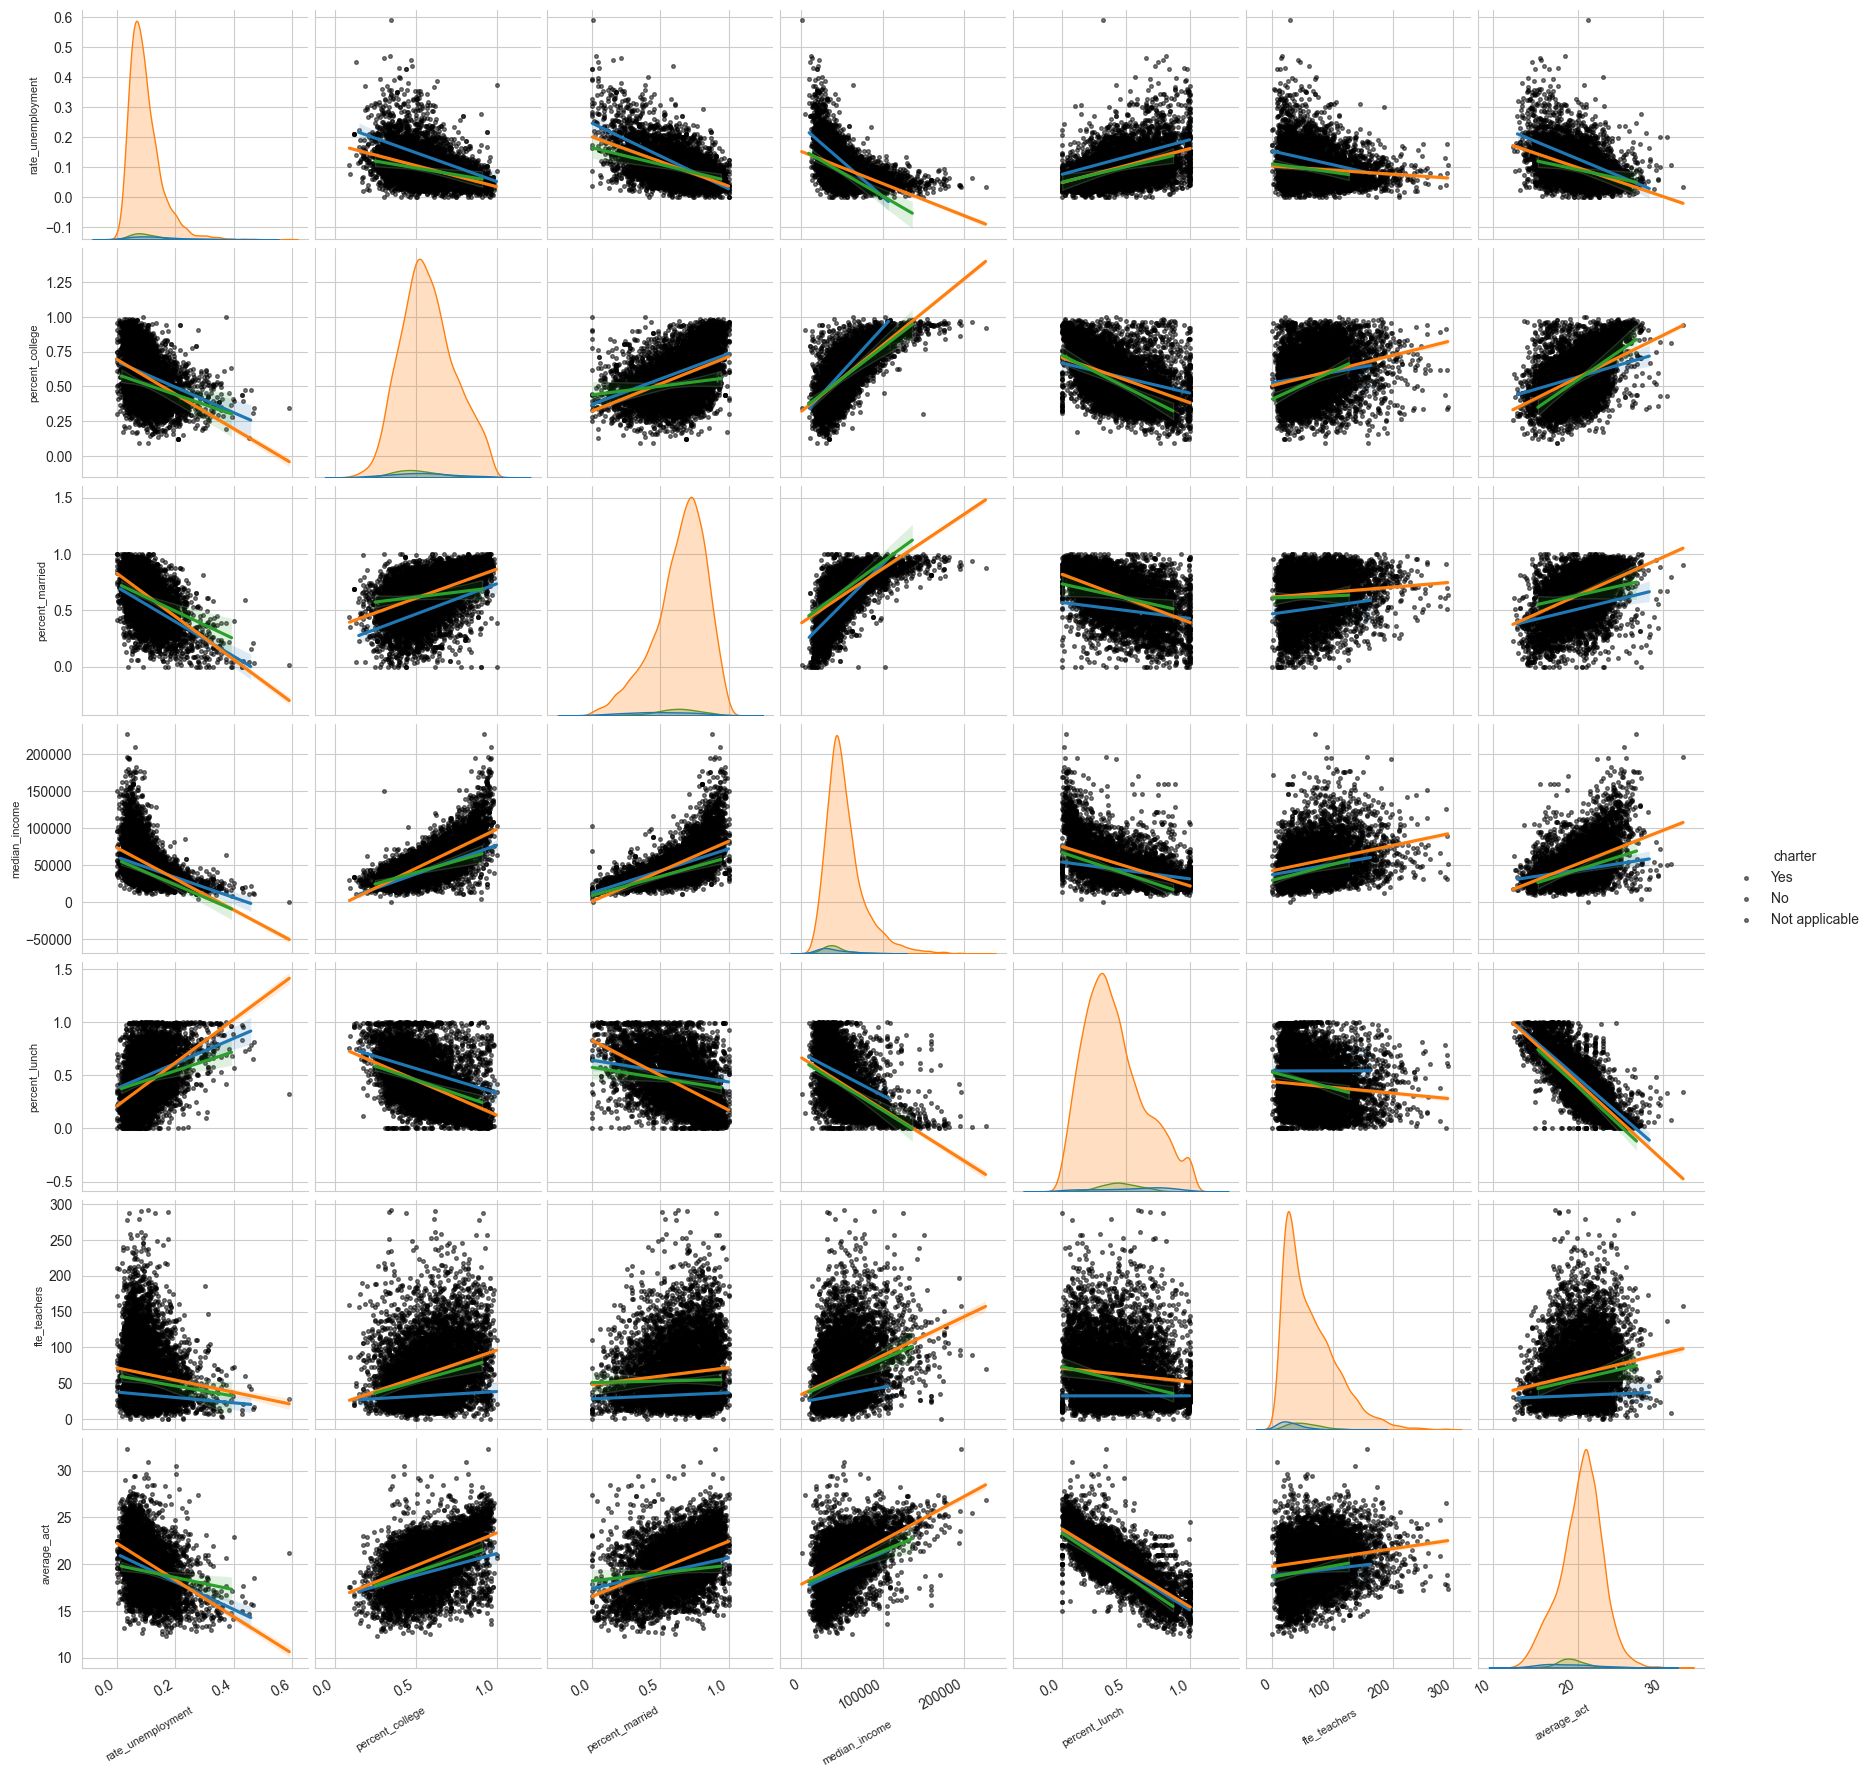

In [62]:
fig = sns.pairplot(
    data=education_df,
    vars=numerical_predictors + ['average_act'],
    hue='charter',
    kind="reg",
    plot_kws={"scatter_kws": {"alpha": 0.5, "color": "k", "s": 7},
    },
)

for ax in fig.axes.flat:
    if ax.get_xlabel() == 'CT Median Household Income':
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))  # Apply scientific notation
    ax.set_xlabel(ax.get_xlabel(), fontsize=8, rotation=30, ha='right')  # X-axis label size and rotation
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)  # Y-axis label size

    # Rotate x-axis tick labels
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

plt.show()

The pairplot shows that several relationships exists between the variables.
Some things noted from the plots:
- the average ACT scores seems to have more of a normal distribution.

To identify the outliers:

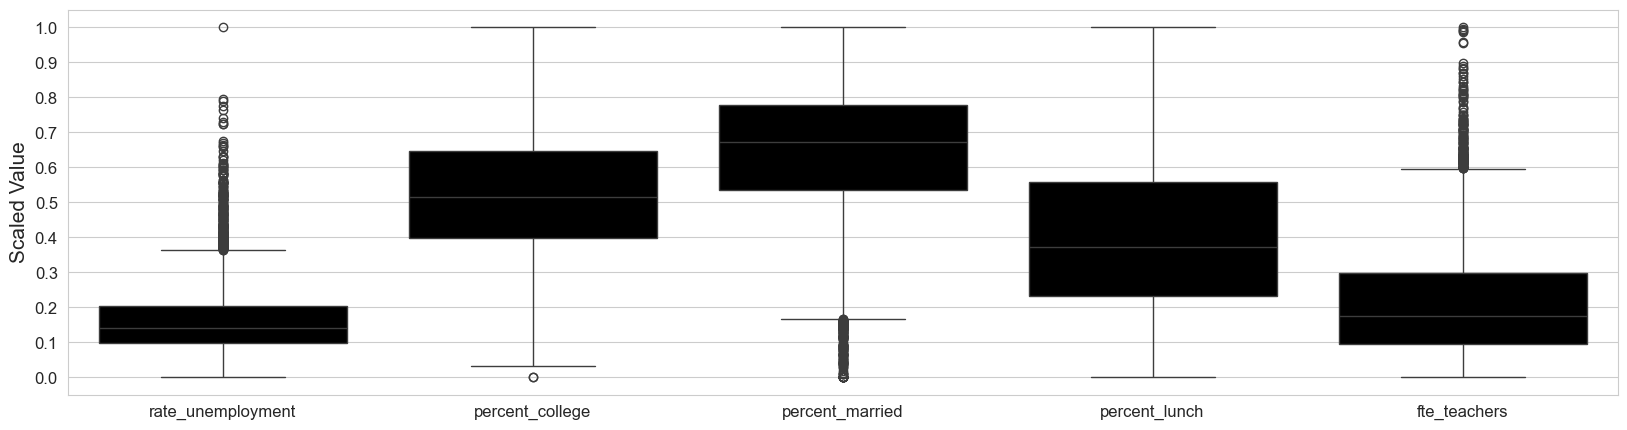

In [63]:


# Scale the variables
fractions = list(numerical_predictors)
fractions.remove('median_income')

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(education_df[fractions])
scaled_df = pd.DataFrame(scaled_data, columns=fractions)

# Plot
plt.figure(figsize=(20,5))
sns.boxplot(data=scaled_df, color='k')

plt.ylabel('Scaled Value', fontsize=15)

# Set y-axis ticks every 0.1 instead of default
plt.gca().yaxis.set_major_locator(MultipleLocator(0.1))

plt.tick_params(labelsize=12)
plt.show()

From the boxplots:
- percent_college and percent_married have a higher median than the other predictor variables. This indicates that on average, the percentage of adults with college degree is high. 
- percent_lunch and percent_college have little or no outliers, this implies that there's little variations between schools. 
- percent_lunch has the widest box indicating much higher variability across districts. 

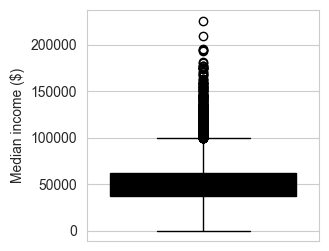

In [64]:
plt.figure(figsize=(3,3))

sns.boxplot(data=education_df, y='median_income', color='k')

plt.ylabel('Median income ($)')

plt.show()

The above shows the box plot of our median income. TH median income lies within 50,000. There are several schools where there is extremely high median incomes. 


Summary:
The numerical predictors are related to average_act. The relationships appear roughly linear.

The numerical predictors are correlated with each other, suggesting that not all predictors will be necessary.

Some variables have skewed distributions, suggesting that transformations of input variables might be useful.

There are outliers in rate_unemployment, percent_college, percent_married, fte_teachers and median_income. 

The relationships are similar across charter and non-charter schools, but might be significantly different.



--------MODELLING-------

To model the relationship between socioeconomic variables and ACT cores:

To begin by using single input models - plotting the relationship between median income and average ACT score:

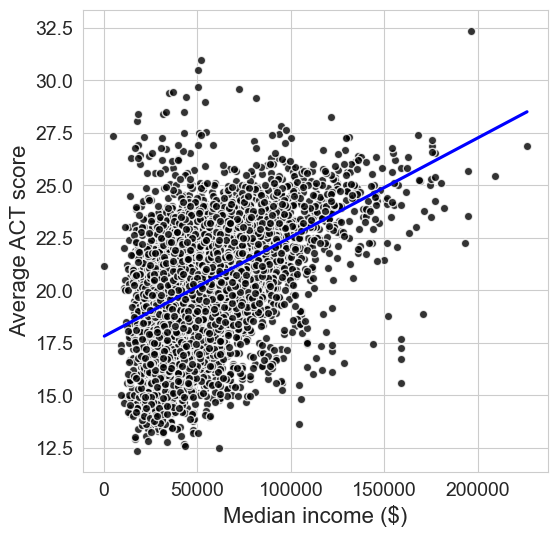

In [65]:
plt.figure(figsize=(6, 6))

sns.regplot(data=education_df,
            x='median_income',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

# Add axis labels
plt.xlabel('Median income ($)', fontsize=16)
plt.ylabel('Average ACT score', fontsize=16)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14)

plt.show()

The plot shows a positive relationship between median income and average ACT score. This suggests that schools located in areas with higher median household income tend to achieve higher average ACT scores. While the trend is not perfect and there is noticeable spread among the points, the overall direction of the relationship is clearly upward, indicating that income is generally associated with stronger academic performance.

To fit the simple linear regression model:

In [66]:
model_median_income = smf.ols(formula='average_act ~ median_income', data=education_df).fit()

To print the fit summary:

In [67]:
print(model_median_income.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     1932.
Date:                Wed, 29 Oct 2025   Prob (F-statistic):               0.00
Time:                        01:45:43   Log-Likelihood:                -16044.
No. Observations:                7227   AIC:                         3.209e+04
Df Residuals:                    7225   BIC:                         3.211e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        17.8035      0.063    284.773

The P-value for predictors indicates we have a statistically significant coefficients. We can see the adisted R-squared.

To perform a numericl assessment of fit accuracy:

In [68]:
print(model_median_income.rsquared)

0.21102083742468947


To obtain the root mean square error:

Obtain the value for y_hat

In [69]:
y_hat = model_median_income.predict()

In [70]:
np.sqrt(mean_squared_error(education_df['average_act'], y_hat)).round(3)

np.float64(2.228)

In [71]:
mean_absolute_error(education_df['average_act'], y_hat)

1.7130706441411383

This is a small error. 

To create pairplot to understand the relationship between Average ACT score and the percentage of adults who have a college degree:

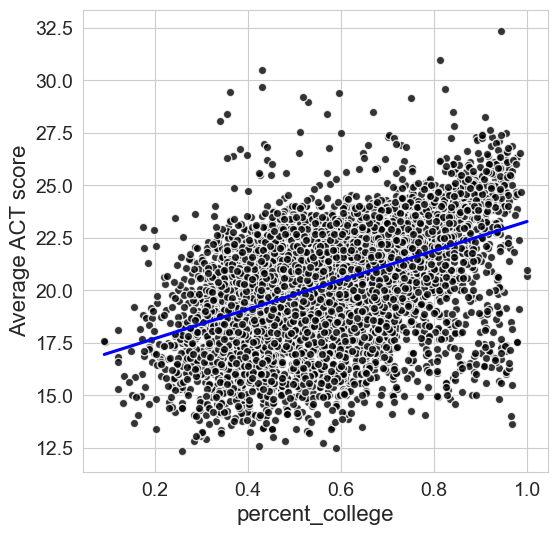

In [72]:
plt.figure(figsize=(6, 6))

sns.regplot(data=education_df,
            x='percent_college',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

# Add axis labels
plt.xlabel('percent_college', fontsize=16)
plt.ylabel('Average ACT score', fontsize=16)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14)

plt.show()

In [73]:
model_percent_college = smf.ols(formula='average_act ~ percent_college', data=education_df).fit()
print(model_percent_college .summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     1920.
Date:                Wed, 29 Oct 2025   Prob (F-statistic):               0.00
Time:                        01:45:43   Log-Likelihood:                -16049.
No. Observations:                7227   AIC:                         3.210e+04
Df Residuals:                    7225   BIC:                         3.212e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          16.3055      0.095    1

From the regression results, we can see that about 21% of variance in the response variable - average ACT scores - is explained by the percentage of adults with a college degree. 


To create pairplot to understand the relationship between Average ACT score and the number of full time teacher equivalent:

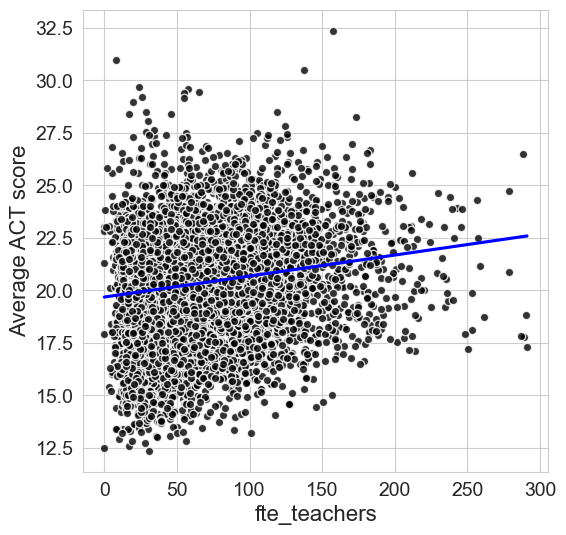

In [74]:
plt.figure(figsize=(6, 6))

sns.regplot(data=education_df,
            x='fte_teachers',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

# Add axis labels
plt.xlabel('fte_teachers', fontsize=16)
plt.ylabel('Average ACT score', fontsize=16)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14)

plt.show()

This plot illustrates the relationship between the number of full-time equivalent (FTE) teachers (fte_teachers) and the average ACT score (average_act) across schools in your dataset. The trend shows a slight positive slope, but it is quite shallow, and the points are widely scattered. This suggests that increasing the number of teachers is not a strong predictor of higher ACT scores.
We cannot infer a causal relationship between these variables. The number of FTE teachers may simply reflect the size of the school—larger schools naturally require more teachers to accommodate their greater student population.

In [75]:
model_fte_teachers = smf.ols(formula='average_act ~ fte_teachers', data=education_df).fit()
print(model_fte_teachers.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     221.3
Date:                Wed, 29 Oct 2025   Prob (F-statistic):           2.56e-49
Time:                        01:45:44   Log-Likelihood:                -16791.
No. Observations:                7227   AIC:                         3.359e+04
Df Residuals:                    7225   BIC:                         3.360e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       19.6757      0.051    385.992   

The R-squared value of 0.03(same for adjusted R-squared) - indicate that fte_teachers does not explain much of the variation in the ACT scores. It indicates that only 3% of the variation in ACT scores is explained by the number of full time equivalent teachers.


To analyze the relationship between average ACT score(average_act) and percentage of students on free/reduced lunch (percent_lunch) using a linear regression:

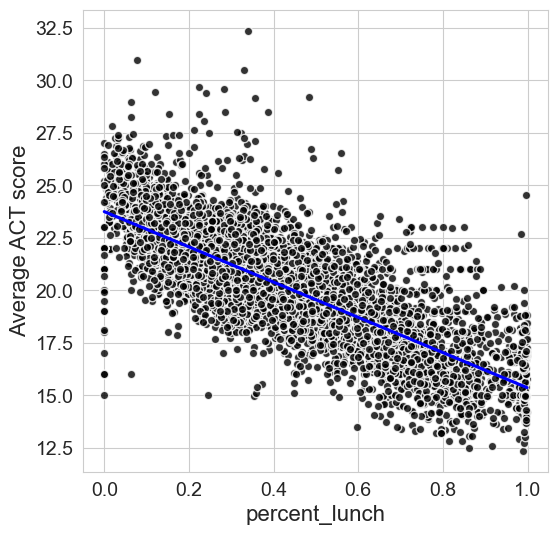

In [76]:
plt.figure(figsize=(6, 6))

sns.regplot(data=education_df,
            x='percent_lunch',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

# Add axis labels
plt.xlabel('percent_lunch', fontsize=16)
plt.ylabel('Average ACT score', fontsize=16)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14)

plt.show()

The plot does show a strong negative relationshiop between percent_lunch and ACT scores. This could indicate that schools with higher percentages of students on free/reduced lunch tend to have lower ACT scores. 

In [77]:
model_percent_lunch = smf.ols(formula='average_act ~ percent_lunch', data=education_df).fit()
print(model_percent_lunch.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                 1.149e+04
Date:                Wed, 29 Oct 2025   Prob (F-statistic):               0.00
Time:                        01:45:44   Log-Likelihood:                -13461.
No. Observations:                7227   AIC:                         2.693e+04
Df Residuals:                    7225   BIC:                         2.694e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        23.7429      0.037    641.759

From the regression results, we can see that about 61.4% of variance in the response variable - average ACT scores - is explained by the percentage of students on free/reduced lunch. 
This is relatively high suggesting that percent_lunch is a strong predictor of ACT score in the dataset. The P-value is less than 0.01 which indicates the relationship is of statistical significance. 

To analyze the relationship between average ACT score(average_act) and the rate_unemployment using a linear regression:

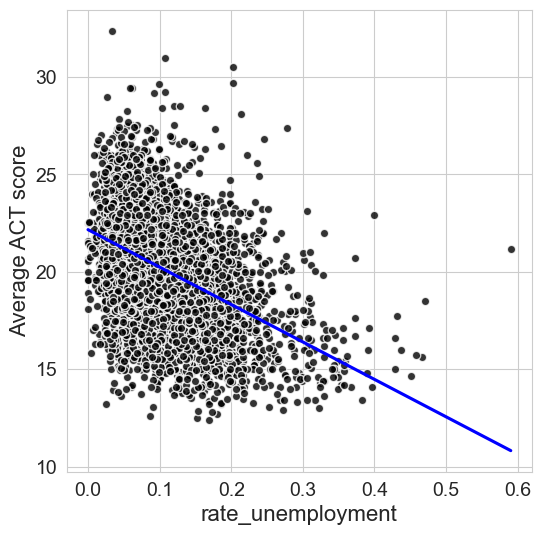

In [78]:
plt.figure(figsize=(6, 6))

sns.regplot(data=education_df,
            x='rate_unemployment',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

# Add axis labels
plt.xlabel('rate_unemployment', fontsize=16)
plt.ylabel('Average ACT score', fontsize=16)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14)

plt.show()

In [79]:
model_rate_unemployment = smf.ols(formula='average_act ~ rate_unemployment', data=education_df).fit()
print(model_rate_unemployment .summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     1669.
Date:                Wed, 29 Oct 2025   Prob (F-statistic):               0.00
Time:                        01:45:44   Log-Likelihood:                -16149.
No. Observations:                7227   AIC:                         3.230e+04
Df Residuals:                    7225   BIC:                         3.232e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.1511      0.05

The regression result does indicate that about 18.8% of variation in ACT scores is explained by unemployment rate. This indicates that a negative relationship can be noticed however unemployment alone does not explain the variation in ACT scores. 
Overall, there is a negative relationship between the unemployment rate and the AC scores - meaning higher unemployment tends to correspond to lower average scores. While there's statistical significance, the R-squared value does indicate that the other factors play a major role in determining the ACT scores. 




To analyze the relationship between percent of adults married(percent_married) within the area and the ACT scores(average_act):

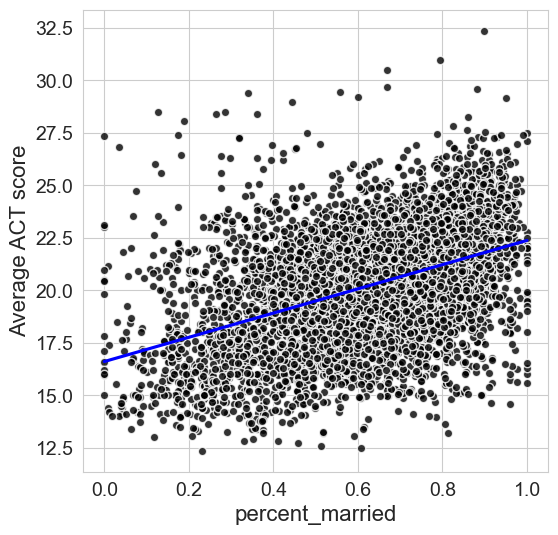

In [80]:
plt.figure(figsize=(6, 6))

sns.regplot(data=education_df,
            x='percent_married',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

# Add axis labels
plt.xlabel('percent_married', fontsize=16)
plt.ylabel('Average ACT score', fontsize=16)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14)

plt.show()

The plot shows there is a positive relationship between the percentage of married adults and average ACT scores. 

In [81]:
model_percent_married = smf.ols(formula='average_act ~ percent_married', data=education_df).fit()
print( model_percent_married.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     1733.
Date:                Wed, 29 Oct 2025   Prob (F-statistic):               0.00
Time:                        01:45:45   Log-Likelihood:                -16124.
No. Observations:                7227   AIC:                         3.225e+04
Df Residuals:                    7225   BIC:                         3.227e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          16.6049      0.093    1

The R^2 indicates that about 19.3# of variation in average ACT is explained by the percentage of married adults in the area. 
The p-value is basically zero which indicates that the model is statistically significant. 
The plots and the regression results would indicate that the areas with higher percentage of marriage adults tend to have higher average ACT scores, but it is important to note that percent_married alone does not explain most of this variation- as there are many other factors that are at play. 

To analyze the relationship between percent of adults married within the median income and ACT scores:

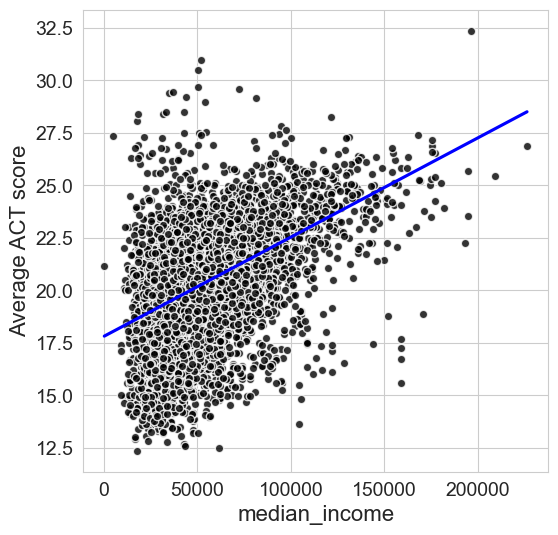

In [82]:
plt.figure(figsize=(6, 6))

sns.regplot(data=education_df,
            x='median_income',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

# Add axis labels
plt.xlabel('median_income', fontsize=16)
plt.ylabel('Average ACT score', fontsize=16)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14)

plt.show()

The plot indicates a positive relationship between median income(median_income) and average ACT score(average_act)

In [83]:
model_median_income = smf.ols(formula='average_act ~ median_income', data=education_df).fit()
print( model_median_income.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     1932.
Date:                Wed, 29 Oct 2025   Prob (F-statistic):               0.00
Time:                        01:45:45   Log-Likelihood:                -16044.
No. Observations:                7227   AIC:                         3.209e+04
Df Residuals:                    7225   BIC:                         3.211e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        17.8035      0.063    284.773

The regression results show that R^2 = 0.211. This indicates that about 21.1% of the variation in ACT scores is explained by median income. This is slightly higher than the percentage of adult married(percent_married).
Based on this we can conclude that income is a better predictor of ACT scores than the marriage rates.  


To assess how well our regression model fits the data and to check for violations of assumptions such as linearity, constant variance, and independence of errors, we plot a residual plot:

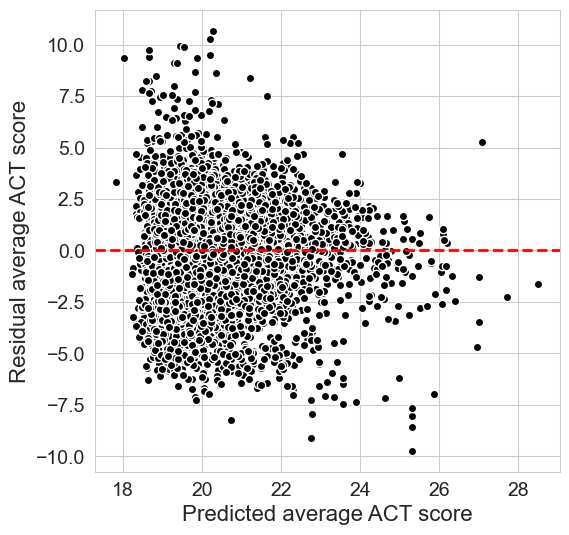

In [84]:
plt.figure(figsize=(6, 6))

plt.plot(y_hat, model_median_income.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

The residual plot shows that the data points are scattered around y = 0, indicating that the linearity assumption is satisfied and that a linear model is likely an appropriate fit for our data.

To further analyze whether the linear regression is a good fit for our model, we can compare it against the non-linear(polynomial) fit. If the linear lines are very close for both then the linear model is sufficient. If not, it suggests that the non linear relationship may fit data better:

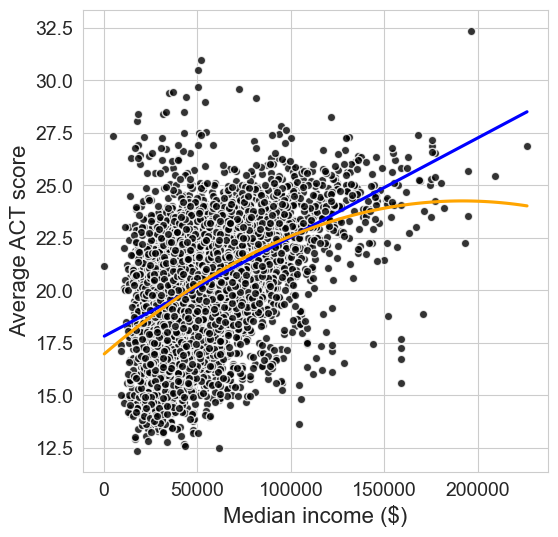

In [85]:
plt.figure(figsize=(6, 6))

sns.regplot(data=education_df,
            x='median_income',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

sns.regplot(data=education_df,
            x='median_income',
            y='average_act',
            order=2,
            color='orange',
            ci=False,
            scatter=False)

# Add axis labels
plt.xlabel('Median income ($)', fontsize=16)
plt.ylabel('Average ACT score', fontsize=16)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14)

plt.show()

Because the blue (linear) and orange (quadratic) lines are almost identical across most of the data, the small deviation around $12,000 is minor. This implies:

A linear model is sufficient to describe the relationship between median income and average ACT score. Adding a quadratic term would not meaningfully improve the model for the majority of the data.

In order to fit a quadratic regression model using statsmodel:


In [86]:
model_median_income2 = smf.ols(
    formula='average_act ~ median_income + I(median_income**2)',
    data=education_df).fit()
print(model_median_income2.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     1012.
Date:                Wed, 29 Oct 2025   Prob (F-statistic):               0.00
Time:                        01:45:46   Log-Likelihood:                -16008.
No. Observations:                7227   AIC:                         3.202e+04
Df Residuals:                    7224   BIC:                         3.204e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                16.94

The model explains about 22% of the variation in ACT scores. Adding a quadratic term improves the model’s fit only slightly, with the R² increasing from 0.211 to 0.219. This suggests that the relationship between median income and ACT scores is largely linear. Therefore, the simple linear model is sufficient for our analysis and effectively captures the main trend in the data.

To access model significance:

In [87]:
model_median_income2.pvalues

Intercept                0.000000e+00
median_income            3.702153e-99
I(median_income ** 2)    1.465328e-17
dtype: float64

Analysis shows we do have signifcant quadratic and linear terms. 

We can also ise an ANOVA to compare the two nested polynomial regression models:

In [88]:
anova_lm(model_median_income, model_median_income2)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,7225.0,35872.544516,0.0,NaN,NaN,NaN
1,7224.0,35513.033433,1.0,359.511083,73.131124,1.465328e-17


The p-value being quite small indicates there is a statistical difference. 

To assess the accuracy of the quadratic model:

We can compute the mean absolute error:

In [89]:
mean_absolute_error(education_df['average_act'], model_median_income2.predict())

1.697246885812138

In [90]:
mean_absolute_error(education_df['average_act'], model_median_income.predict())

1.7130706441411383

The quadratic model performs slightly better, as it has a lower MAE (1.697 vs. 1.713). However, the improvement is very small — less than 0.02 ACT points — which is practically negligible. Therefore, the linear model is sufficient for your purposes since it’s simpler and almost as accurate.

So far, we have assessed all the socioeconomic factors independently against ACT. It is important however to fit a multiple linear regression that takes into account all the socioeconomic predictors.
To fit a multiple linear regression model that takes into account all the socioeconomic predictors:


In [91]:
model = smf.ols(
    formula='average_act ~ rate_unemployment + percent_college + percent_married + median_income + percent_lunch +fte_teachers',
    data=education_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     2062.
Date:                Wed, 29 Oct 2025   Prob (F-statistic):               0.00
Time:                        01:45:46   Log-Likelihood:                -13293.
No. Observations:                7227   AIC:                         2.660e+04
Df Residuals:                    7220   BIC:                         2.665e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.6068      0.13

The Regression results indicate that about 63% of variation in ACT scores across districts is explained by the 6 socioeconomical variables. 
We note that for the predictor variables whose P-value < 0.05 such as rate_unemployment, percent_college, percent_lunch and fte_teachers they are significant predictors of ACT scores. median_income and percent_lunch which have their p-value>0.05 are a non-significant predictor of the ACT scores.

To use a residual plot for graphical asseeement of the model fit:

In [92]:
y_hat = model.predict()

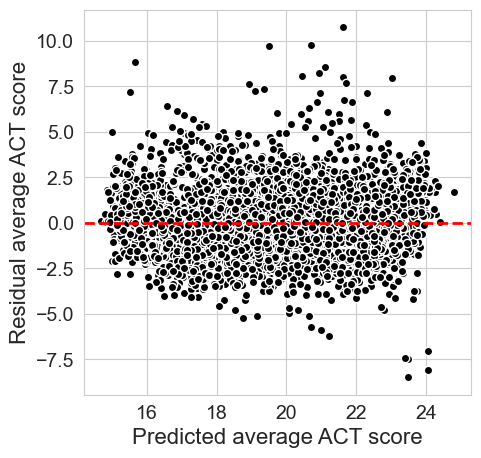

In [93]:
plt.figure(figsize=(5, 5))

plt.plot(y_hat, model.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

The residual plot above shows no clear pattern or systematic structure, and the residuals appear to be randomly scattered around the horizontal line at y = 0. This suggests that the assumptions of linearity and homoscedasticity (constant variance of residuals) are reasonably met. Therefore, applying transformations to the predictors or the response variable is unlikely to significantly improve the model fit.

Next, we calculate the mean absolute error to determine on average, how far the model's predictions are from the actual values. 
To compute mean absolute error:

In [94]:
mean_absolute_error(education_df['average_act'], model.predict())

1.1360371434414531

The mean absolute error tells us that on average the predicted ACT score differs from the actual ACT score about 1.14. Given the average range of values seem to be between 12 and 25, the relatively small error tells us that the model provides strong evidence that we can that the prediction are accurate. 

To fit the reduced model with significant predictors:

To reduce noise and multicollinearity, we construct a reduced model using only the significant predictors. This reduced model includes only those socioeconomic variables whose coefficients were statistically significant, allowing us to determine whether these key factors are sufficient to accurately predict the average ACT score.

In [95]:
model_reduced = smf.ols(
    formula='average_act ~ rate_unemployment + percent_college + percent_lunch+ fte_teachers',
    data=education_df).fit()
print(model_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     3091.
Date:                Wed, 29 Oct 2025   Prob (F-statistic):               0.00
Time:                        01:45:46   Log-Likelihood:                -13295.
No. Observations:                7227   AIC:                         2.660e+04
Df Residuals:                    7222   BIC:                         2.663e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.5853      0.10

Note that the R-squared value of 0.631 is the same for both the reduced model and the original model. This indicates that the reduced model with only the significant predictors captures basically the same amout of variation in the ACT score as the full model.

We can use residual plot for graphical assessment of model fit:

y_hat = model_reduced.predict()

In [96]:
y_hat = model_reduced.predict()

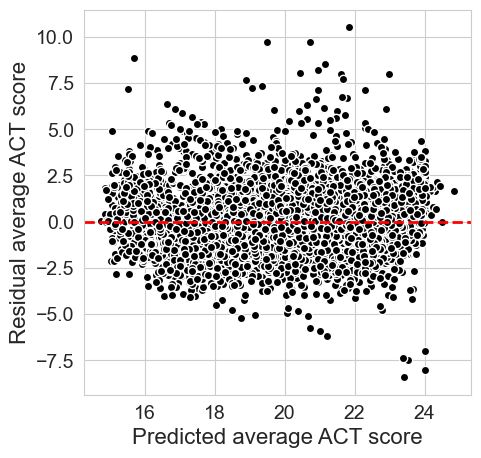

In [97]:
plt.figure(figsize=(5, 5))

plt.plot(y_hat, model_reduced.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

The reduced model shows no evidence that transformations of the selected significant predictors are necessary. The predictors in their original form are sufficient to explain variation in ACT scores, as indicated by the model’s R^2 and MAE, which are nearly identical to those of the full model.


To calculate the mean absolute error for the reduced model:

In [98]:
mean_absolute_error(education_df['average_act'], model_reduced.predict())

1.1368182496482144

The mean absolube error of the reduced model is roughly identical to that of the the full model 1.1360371434414531. The small error indicates that that the reduced model is quite adequate at predicting ACT scores.

To compare the accuracy between the full and reduced model: 

In [99]:
mae_full = mean_absolute_error(education_df['average_act'], model.predict())
mae_reduced = mean_absolute_error(education_df['average_act'], model_reduced.predict())

r2_full = model.rsquared
r2_reduced = model_reduced.rsquared

pd.DataFrame({'Mean Absolute Error': [mae_full, mae_reduced],
              'R-squared': [r2_full, r2_reduced]},
              index=['full model', 'reduced model']).round(4)

,Mean Absolute Error,R-squared
full model,1.1360,0.6315
reduced model,1.1368,0.6313


We see that the values are very identical for both. 

To formally confirm our observations, we can use an ANOVA test. This acts as a statistical check and provides a p-value, allowing us to rigorously assess whether the reduced model performs similarly to the full model.

Null Hypothesis (H₀): There is no difference between the full model and the reduced model.

Alternative Hypothesis (H₁): There is a difference between the full model and the reduced model .

In [100]:
anova_lm(model_reduced, model)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,7222.0,16763.883211,0.0,NaN,NaN,NaN
1,7220.0,16756.353915,2.0,7.529297,1.622117,0.197552


From the ANOVA computation output, F = 1.622 and the P-value = 0.197552. Since the p-value is greater than 0.05, we fail to reject the null hypothesis. This indicates that there is no statistically significant difference between the full model and reduced model. 

--------EVALUATION-------

At this stage, we want to reflect on the work and critically evaluate how well we have been able to answer the question.

- Did you formulate the question in such a way that it addresses the original problem and can be answered with data? 
Yes, this was done by ensuring we obtained accurate data and looked at the relationship between the social economic variables and the response variable. 
- Were there limitations in the quality of the data?
There was some issues regarding the completeness of data. Some of the day were missing for particular varaibles and some data were incorrect and those incorrect data had to be dropped. Overall, the data was good enough once we handled the problems with the data. 



- Did the results (graphs, summaries, regression models) allow you to answer the question? Can you state quantitatively how well you can explain the average ACT score using the socioeconomic predictors?
Yes, the graphs were able to provide insights into the relationship between the variables but the regression models did a better job in giving us insights into which socioeconomic predictor had a greater influence on ACT_score.
- Which variable is the strongest predictor of the average ACT score? Why might the percentage of students eligible for free or reduced price lunch be a stronger prediction than the median income?
You should consider these questions when you participate in the class discussion about your evaluation of the work.
Based on the regression models, it would seem that percent_lunch was a greater predictor of average ACT score than the other socioeconomic variabbles. 



School percentage free and reduced lunch was the most important predictor and we have income as our main variable 

One thing that is important is percentage of school free and reduced lunch is the only data measured for the school. the rest are for beyond the school. 



Note that when reviewing regression we are not trying to establish a causal relationship - one does not cause another. The way we interpret this model is looking at the relationship.